🖥️  Device: cpu
📁 Data path: /content/drive/MyDrive/PC Importation/CobotProject/wallplugs
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📊 train: 293 images chargées
📊 test_public: 150 images chargées
🚀 ENTRAÎNEMENT

🔧 Extraction des features d'entraînement...


Extraction features: 100%|██████████| 74/74 [01:09<00:00,  1.07it/s]


✅ Memory bank créée: (100, 384)
💾 Modèle sauvegardé : /content/drive/MyDrive/PC Importation/CobotProject/wallplugs/patchcore_model.pth
🧪 ÉVALUATION

🔍 Détection des anomalies...


Prédiction: 100%|██████████| 38/38 [00:50<00:00,  1.33s/it]


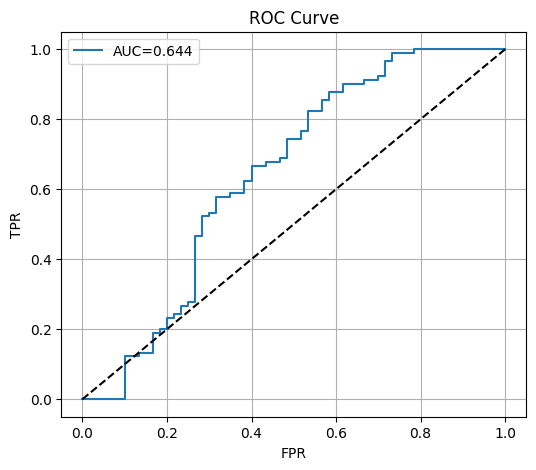

📊 AUC-ROC: 0.6444


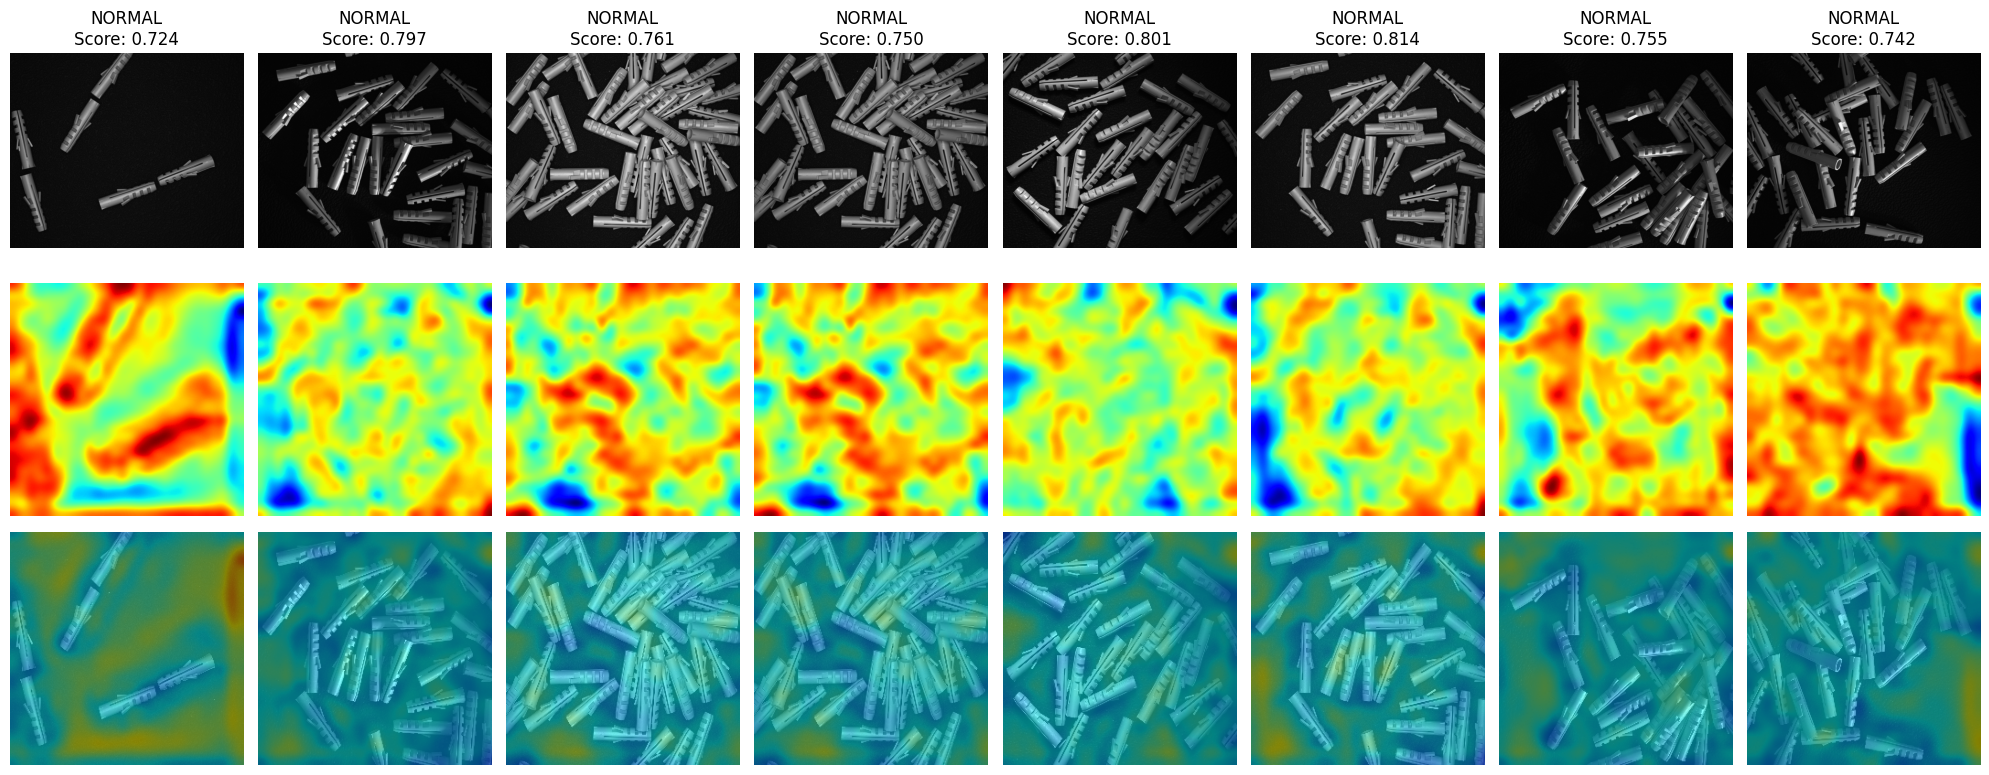

🔮 TEST PRIVÉ
📊 test_mixed: 232 images chargées

🔍 Détection des anomalies...


Prédiction: 100%|██████████| 58/58 [01:26<00:00,  1.49s/it]

✅ Fichier sauvegardé: /content/predictions_private.json

✨ Terminé!


In [6]:
"""
PatchCore Anomaly Detection for Wall Plugs - Google Colab
Version avec sauvegarde et chargement du modèle
"""

# ========================================
# 1. INSTALLATION DES DÉPENDANCES
# ========================================
!pip install torch torchvision timm scikit-learn scipy matplotlib seaborn opencv-python Pillow tqdm -q

# ========================================
# 2. IMPORTS
# ========================================
import os
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import timm
from sklearn.metrics import roc_auc_score, roc_curve
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import cv2
import json
import gc  # Garbage collector pour libérer mémoire

# ========================================
# 3. CONFIGURATION
# ========================================
class Config:
    DATA_PATH = "/content/drive/MyDrive/PC Importation/CobotProject/wallplugs"
    TRAIN_PATH = os.path.join(DATA_PATH, "train/good")
    TEST_PUBLIC_PATH = os.path.join(DATA_PATH, "test_public")
    TEST_PRIVATE_PATH = os.path.join(DATA_PATH, "test_private_mixed")

    BACKBONE = "resnet18"
    LAYERS = ["layer2", "layer3"]
    IMG_SIZE = 256
    BATCH_SIZE = 4

    CORESET_SAMPLING_RATIO = 0.01
    N_NEIGHBORS = 1

    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    SEED = 42
    MAX_MEMORY_BANK_SIZE = 5000

config = Config()
print(f"🖥️  Device: {config.DEVICE}")
print(f"📁 Data path: {config.DATA_PATH}")

# ========================================
# 4. DATASET
# ========================================
class WallPlugDataset(Dataset):
    def __init__(self, root_path, transform=None, mode='train'):
        self.transform = transform
        self.mode = mode
        self.images, self.labels, self.masks = [], [], []

        if mode == 'train':
            img_dir = os.path.join(root_path, "train/good")
            for img_name in os.listdir(img_dir):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.images.append(os.path.join(img_dir, img_name))
                    self.labels.append(0)
                    self.masks.append(None)

        elif mode == 'test_public':
            good_dir = os.path.join(root_path, "test_public/good")
            bad_dir = os.path.join(root_path, "test_public/bad")
            gt_dir = os.path.join(root_path, "test_public/ground_truth/bad")

            if os.path.exists(good_dir):
                for img_name in os.listdir(good_dir):
                    if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                        self.images.append(os.path.join(good_dir, img_name))
                        self.labels.append(0)
                        self.masks.append(None)

            if os.path.exists(bad_dir):
                for img_name in os.listdir(bad_dir):
                    if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                        img_path = os.path.join(bad_dir, img_name)
                        self.images.append(img_path)
                        self.labels.append(1)

                        mask_name = img_name.replace('.jpg', '_mask.png').replace('.png', '_mask.png')
                        mask_path = os.path.join(gt_dir, mask_name)
                        self.masks.append(mask_path if os.path.exists(mask_path) else None)

        elif mode == 'test_mixed':
            mixed_dir = os.path.join(root_path, "test_private_mixed")
            if os.path.exists(mixed_dir):
                for img_name in os.listdir(mixed_dir):
                    if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                        self.images.append(os.path.join(mixed_dir, img_name))
                        self.labels.append(-1)
                        self.masks.append(None)

        print(f"📊 {mode}: {len(self.images)} images chargées")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = Image.open(self.images[idx]).convert('RGB')
        label = self.labels[idx]

        if self.masks[idx] is not None:
            mask = cv2.imread(self.masks[idx], cv2.IMREAD_GRAYSCALE)
            mask = (mask > 0).astype(np.float32)
        else:
            mask = np.zeros((img.size[1], img.size[0]), dtype=np.float32)

        if self.transform:
            img = self.transform(img)

        return img, label, mask, self.images[idx]

# ========================================
# 5. FEATURE EXTRACTOR (ResNet)
# ========================================
class FeatureExtractor(torch.nn.Module):
    def __init__(self, backbone_name="resnet18", layers=["layer2", "layer3"]):
        super().__init__()
        self.backbone = timm.create_model(
            backbone_name,
            pretrained=True,
            features_only=True,
            out_indices=[2, 3]
        )
        self.backbone.eval()
        self.layers = layers

    def forward(self, x):
        return self.backbone(x)

# ========================================
# 6. PATCHCORE MODEL + SAUVEGARDE
# ========================================
class PatchCore:
    def __init__(self, config):
        self.config = config
        self.feature_extractor = FeatureExtractor(config.BACKBONE, config.LAYERS).to(config.DEVICE)
        self.memory_bank = None

    def extract_features(self, dataloader):
        all_features = []
        with torch.no_grad():
            for imgs, _, _, _ in tqdm(dataloader, desc="Extraction features"):
                imgs = imgs.to(self.config.DEVICE)
                features = self.feature_extractor(imgs)
                resized_features = []
                for feat in features:
                    feat_resized = F.interpolate(feat, size=(28, 28), mode='bilinear', align_corners=False)
                    resized_features.append(feat_resized)
                concat_features = torch.cat(resized_features, dim=1)
                B, C, H, W = concat_features.shape
                concat_features = concat_features.permute(0, 2, 3, 1).reshape(B, H*W, C)
                all_features.append(concat_features.cpu().numpy())
                del imgs, features, resized_features, concat_features
                torch.cuda.empty_cache()
        all_features = np.concatenate(all_features, axis=0)
        all_features = all_features.reshape(-1, all_features.shape[-1])
        return all_features

    def fit(self, train_loader):
        print("\n🔧 Extraction des features d'entraînement...")
        features = self.extract_features(train_loader)
        from sklearn.preprocessing import normalize
        features = normalize(features, norm='l2', axis=1)
        max_features = min(len(features), self.config.MAX_MEMORY_BANK_SIZE * 2)
        if len(features) > max_features:
            indices = np.random.choice(len(features), max_features, replace=False)
            features = features[indices]
        n_samples = min(int(len(features) * self.config.CORESET_SAMPLING_RATIO), self.config.MAX_MEMORY_BANK_SIZE)
        indices = np.random.choice(len(features), n_samples, replace=False)
        self.memory_bank = features[indices]
        del features
        gc.collect()
        print(f"✅ Memory bank créée: {self.memory_bank.shape}")

    def predict(self, test_loader):
        print("\n🔍 Détection des anomalies...")
        all_scores, all_labels, all_maps, all_paths = [], [], [], []
        with torch.no_grad():
            for imgs, labels, _, paths in tqdm(test_loader, desc="Prédiction"):
                imgs = imgs.to(self.config.DEVICE)
                features = self.feature_extractor(imgs)
                resized_features = [F.interpolate(f, size=(28, 28), mode='bilinear', align_corners=False) for f in features]
                concat_features = torch.cat(resized_features, dim=1)
                B, C, H, W = concat_features.shape
                test_features = concat_features.permute(0, 2, 3, 1).reshape(B, H*W, C).cpu().numpy()
                from sklearn.preprocessing import normalize
                for i in range(B):
                    patches = normalize(test_features[i], norm='l2', axis=1)
                    anomaly_scores = []
                    for j in range(0, len(patches), 100):
                        batch = patches[j:j+100]
                        distances = np.linalg.norm(batch[:, None, :] - self.memory_bank[None, :, :], axis=2)
                        anomaly_scores.extend(np.min(distances, axis=1))
                    anomaly_map = np.array(anomaly_scores).reshape(H, W)
                    anomaly_map = cv2.resize(anomaly_map, (self.config.IMG_SIZE, self.config.IMG_SIZE))
                    anomaly_map = gaussian_filter(anomaly_map, sigma=4)
                    all_maps.append(anomaly_map)
                    all_scores.append(np.max(anomaly_map))
                    all_labels.append(labels[i].item())
                    all_paths.append(paths[i])
        return np.array(all_scores), np.array(all_labels), all_maps, all_paths

    # ---------- Sauvegarde et chargement ----------
    def save(self, path="patchcore_model.pth"):
        checkpoint = {
            'memory_bank': self.memory_bank,
            'backbone_state_dict': self.feature_extractor.state_dict(),
            'config': vars(self.config)
        }
        torch.save(checkpoint, path)
        print(f"💾 Modèle sauvegardé : {path}")

    def load(self, path="patchcore_model.pth"):
        checkpoint = torch.load(path, map_location=self.config.DEVICE)
        self.memory_bank = checkpoint['memory_bank']
        self.feature_extractor.load_state_dict(checkpoint['backbone_state_dict'])
        print(f"✅ Modèle chargé depuis : {path}")
        print(f"📊 Memory bank shape : {self.memory_bank.shape}")

# ========================================
# 7. VISUALISATION ET MÉTRIQUES
# ========================================
def visualize_results(images, labels, scores, anomaly_maps, n_samples=8):
    fig, axes = plt.subplots(3, n_samples, figsize=(20, 8))
    for i in range(min(n_samples, len(images))):
        img = np.array(Image.open(images[i]).convert('RGB'))
        axes[0, i].imshow(img)
        axes[0, i].set_title(f"{'ANOMALY' if labels[i]==1 else 'NORMAL'}\nScore: {scores[i]:.3f}")
        axes[0, i].axis('off')
        axes[1, i].imshow(anomaly_maps[i], cmap='jet'); axes[1, i].axis('off')
        heatmap = cv2.applyColorMap((anomaly_maps[i]*255).astype(np.uint8), cv2.COLORMAP_JET)
        overlay = cv2.addWeighted(cv2.resize(img,(config.IMG_SIZE,config.IMG_SIZE)),0.5,heatmap,0.5,0)
        axes[2, i].imshow(overlay); axes[2, i].axis('off')
    plt.tight_layout(); plt.show()

def plot_metrics(labels, scores):
    fpr, tpr, _ = roc_curve(labels, scores)
    auc_score = roc_auc_score(labels, scores)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f'AUC={auc_score:.3f}'); plt.plot([0,1],[0,1],'k--')
    plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC Curve'); plt.legend(); plt.grid()
    plt.show()
    print(f"📊 AUC-ROC: {auc_score:.4f}")

# ========================================
# 8. MAIN
# ========================================
def main():
    gc.collect(); torch.cuda.empty_cache()

    transform = transforms.Compose([
        transforms.Resize((config.IMG_SIZE, config.IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
    ])

    train_dataset = WallPlugDataset(config.DATA_PATH, transform=transform, mode='train')
    test_dataset = WallPlugDataset(config.DATA_PATH, transform=transform, mode='test_public')
    train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE, shuffle=False)

    model = PatchCore(config)

    print("="*60); print("🚀 ENTRAÎNEMENT"); print("="*60)
    model.fit(train_loader)
    model.save("/content/drive/MyDrive/PC Importation/CobotProject/wallplugs/patchcore_model.pth")

    print("="*60); print("🧪 ÉVALUATION"); print("="*60)
    scores, labels, maps, paths = model.predict(test_loader)
    mask = labels != -1
    if len(np.unique(labels[mask])) > 1:
        plot_metrics(labels[mask], scores[mask])
    visualize_results(paths, labels, scores, maps, n_samples=8)

    # Prédictions test privé
    if os.path.exists(config.TEST_PRIVATE_PATH):
        print("="*60); print("🔮 TEST PRIVÉ"); print("="*60)
        mixed_dataset = WallPlugDataset(config.DATA_PATH, transform=transform, mode='test_mixed')
        mixed_loader = DataLoader(mixed_dataset, batch_size=config.BATCH_SIZE, shuffle=False)
        mixed_scores, _, mixed_maps, mixed_paths = model.predict(mixed_loader)
        results = []
        threshold = np.percentile(scores[mask], 95)
        for path, score in zip(mixed_paths, mixed_scores):
            results.append({
                'image': os.path.basename(path),
                'anomaly_score': float(score),
                'prediction': 'ANOMALY' if score > threshold else 'NORMAL'
            })
        with open('/content/predictions_private.json', 'w') as f:
            json.dump(results, f, indent=2)
        print("✅ Fichier sauvegardé: /content/predictions_private.json")

    print("\n✨ Terminé!")

# ========================================
# 9. LANCEMENT
# ========================================
if __name__ == "__main__":
    from google.colab import drive
    drive.mount('/content/drive')
    torch.manual_seed(config.SEED); np.random.seed(config.SEED)
    main()


In [3]:
!ls -lh /content/predictions_private.json


-rw-r--r-- 1 root root 25K Nov  9 17:23 /content/predictions_private.json


In [5]:
    def save(self, path="patchcore_model.pth"):
        """Sauvegarde du modèle (memory bank + config)"""
        checkpoint = {
            'memory_bank': self.memory_bank,
            'config': vars(self.config)
        }
        torch.save(checkpoint, path)
        print(f"💾 Modèle sauvegardé : {path}")

    def load(self, path="patchcore_model.pth"):
        """Chargement du modèle sauvegardé"""
        checkpoint = torch.load(path, map_location=self.config.DEVICE)
        self.memory_bank = checkpoint['memory_bank']
        print(f"✅ Modèle chargé depuis : {path}")
        print(f"📊 Memory bank shape : {self.memory_bank.shape}")
